In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import seaborn as sns
import string
import pickle # save data frame (results) in a .pkl file
import pandas as pd
from datetime import datetime
import os, sys
import re


sys.path.insert(0, 'C:/Users/User/Code/MMDGraph')
#from importlib import reload
from mmdutils import readfoldertopanda, PlotROCGeneral, plotVaryingBGDEG, findAUC
#reload(readfoldertopanda)
import importlib
importlib.reload(sys.modules['mmdutils'])
from mmdutils import readfoldertopanda, PlotROCGeneral, plotVaryingBGDEG, findAUC

In [3]:
def gen_theta(k, sparsity, seed):
    np.random.seed(seed=seed)
    # generate the symmetric sparsity mask
    mask = np.random.uniform(size = k)
    mask = mask * (mask < sparsity)
    mask = np.triu(mask)
    mask = mask + mask.T + np.identity(k)
    mask[mask > 0] = 1

    # generate the symmetric precision matrix
    theta = np.random.normal(size = (k,k))
    theta = np.random.normal(size = (k,k))
    theta = np.triu(theta)
    theta = theta + theta.T + np.identity(k)

    # apply the reqired sparsity
    theta = theta * mask

    l, _ = np.linalg.eigh(theta)
    # force it to be positive definite
    theta = theta - (np.min(l)-.1) * np.identity(k)

    return theta

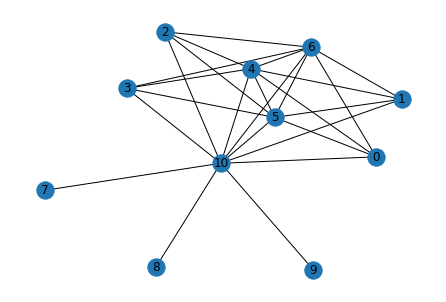

In [75]:
theta1 = gen_theta(11, 0.5, 42)
pd.DataFrame(theta1).to_excel("../../theta1.xlsx")
np.fill_diagonal(theta1,0)
G1 = nx.from_numpy_array(theta1)
pos = nx.kamada_kawai_layout(G1, weight = None)
nx.draw(G1, pos = pos, with_labels = True)

In [77]:
np.linspace(start = 0, stop = 0.5, num = 20)

array([0.        , 0.02631579, 0.05263158, 0.07894737, 0.10526316,
       0.13157895, 0.15789474, 0.18421053, 0.21052632, 0.23684211,
       0.26315789, 0.28947368, 0.31578947, 0.34210526, 0.36842105,
       0.39473684, 0.42105263, 0.44736842, 0.47368421, 0.5       ])

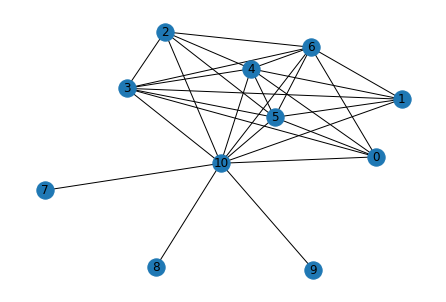

In [76]:
theta2 = gen_theta(11, 0.6, 42)
pd.DataFrame(theta2).to_excel("../../theta2.xlsx")
np.fill_diagonal(theta2,0)
G2 = nx.from_numpy_array(theta2)
nx.draw(G2, pos = pos, with_labels = True)

In [74]:
pd.DataFrame(theta2).to_excel("../../theta2.xlsx")

In [23]:
Gs1 = []
Gs2 = []
error_1 = []
error_2 = []
n = 50

for i in range(50):
    x1 = np.random.multivariate_normal(mean = np.zeros(k), cov = theta, size = 20)
    A1 = np.corrcoef(x1.T)
    if alpha == 0:
        np.fill_diagonal(A1, 0)
    else:
        gl = graphical_lasso(A1, alpha = alpha, max_iter = 1000)
        A1 = gl[0]
        np.fill_diagonal(A1, 0)

    Gs1.append(nx.from_numpy_matrix(A1))
    error_1.append(np.sum(np.logical_xor(np.abs(np.triu(A1,1)) > 0,np.abs(np.triu(theta,1)) > 0)))
    x2 = np.random.multivariate_normal(mean = np.zeros(k), cov = theta, size = 20)
    A2 = np.corrcoef(x2.T)
    if alpha == 0:
        np.fill_diagonal(A2, 0)
    else:
        gl = graphical_lasso(A2, alpha = alpha, max_iter = 1000)
        A2 = gl[0]
        np.fill_diagonal(A2, 0)
    Gs2.append(nx.from_numpy_matrix(A2))
    error_2.append(np.sum(np.logical_xor(np.abs(np.triu(A2,1)) > 0,np.abs(np.triu(theta,1)) > 0)))


In [28]:
x1 = np.random.multivariate_normal(mean = np.zeros(k), cov = theta, size = 20)
A1 = np.corrcoef(x1.T)
if alpha == 0:
    np.fill_diagonal(A1, 0)
else:
    gl = graphical_lasso(theta, alpha = alpha, max_iter = 1000)
    A1 = gl[0]
    np.fill_diagonal(A1, 0)

In [14]:
data = readfoldertopanda('../data/GLasso/')
data.columns

Index(['p_val', 'sample', 'mean_error_1', 'mean_error_2', 'alpha', 's1', 's2'], dtype='object')

In [27]:
def plot_glasso(data, title = None):
    alphas = np.unique(data['alpha'])
    rejection_rate1 = []
    rejection_rate5 = []
    rejection_rate10 = []
    mean_error_1 = []
    mean_error_2 = []
    for alpha in alphas:
        N = len(data['p_val'].loc[data['alpha'] == alpha])
        rejection_rate1.append(np.sum(data['p_val'].loc[data['alpha'] == alpha] <0.01)/N)
        rejection_rate5.append(np.sum(data['p_val'].loc[data['alpha'] == alpha] <0.05)/N)
        rejection_rate10.append(np.sum(data['p_val'].loc[data['alpha'] == alpha] <0.1)/N)
        mean_error_1.append(np.mean(data['mean_error_1'].loc[data['alpha'] == alpha]))
        mean_error_2.append(np.mean(data['mean_error_2'].loc[data['alpha'] == alpha]))


    fig, ax = plt.subplots(1,1, figsize=(15,10))

    ax.axhline(y=0.05, color = 'black', alpha = 0.5, linestyle = 'dashed')

    ax.plot(alphas,rejection_rate1, label = r'Prop. rejected at $\alpha = 0.01$')
    ax.plot(alphas,rejection_rate5, label = r'Prop. rejected at $\alpha = 0.05$')
    ax.plot(alphas,rejection_rate10, label = r'Prop. rejected at $\alpha = 0.1$')
    ax.plot(alphas,np.array(mean_error_1)*0.01, label = 'Mean error of sample 1')
    ax.plot(alphas,np.array(mean_error_2)*0.01, label = 'Mean error of sample 1')
    ax.set_ylabel("Prop. rejected")
    ax.set_ylim([0, 0.8])
    ax.set_xlabel("Regularization")
    ax.legend()

    def fun1(x):
        return x/0.01

    def fun2(x):
        return x*0.01


    secax_y = ax.secondary_yaxis(
        'right', functions=(fun1, fun2))
    secax_y.set_ylabel('Error')

    ax.set_title(title)

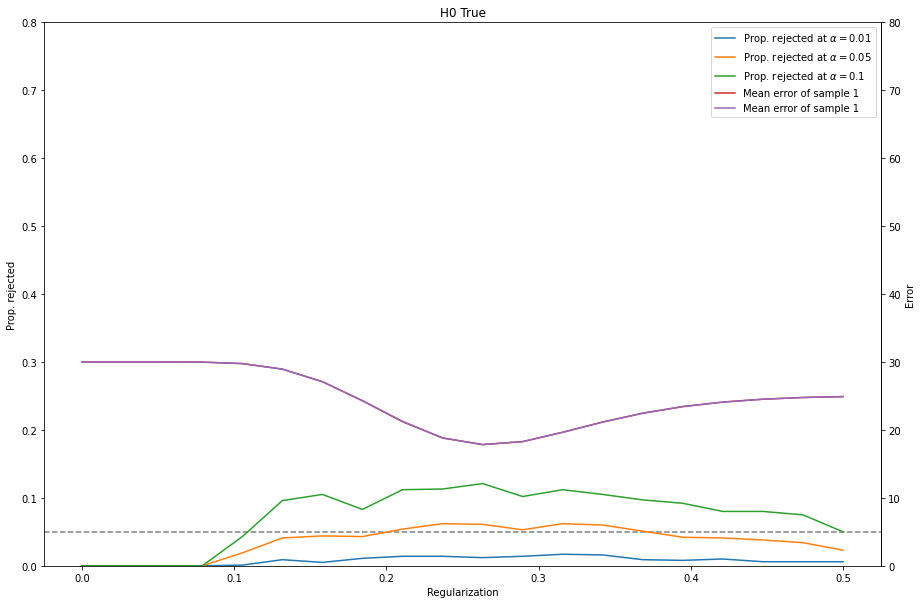

In [28]:
h0_true = data.loc[(data['s1'] == 0.5) & (data['s2'] == 0.5)]
plot_glasso(h0_true, "H0 True")

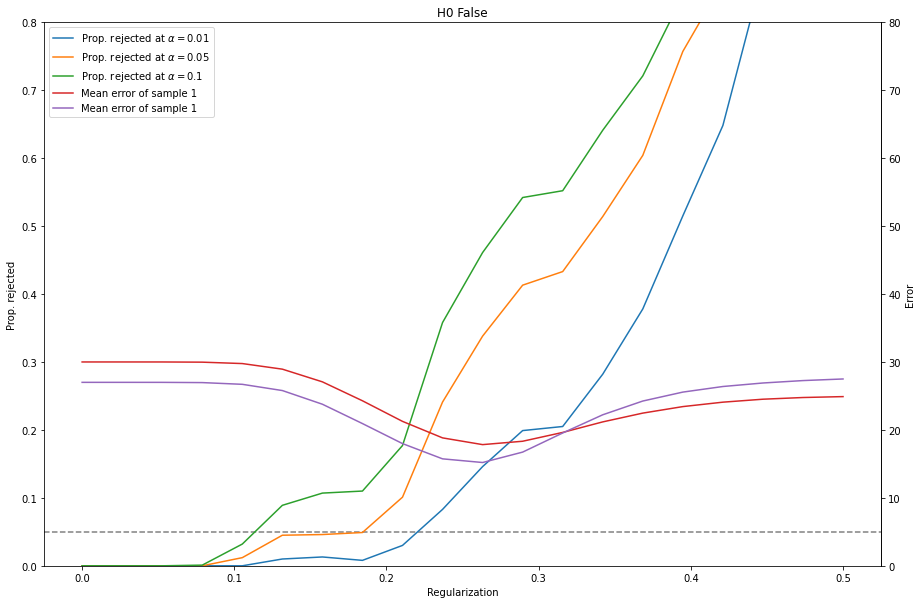

In [29]:
h0_false = data.loc[(data['s1'] == 0.5) & (data['s2'] == 0.6)]
plot_glasso(h0_false, "H0 False")